In [31]:

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [32]:
# Load the dataset
df = pd.read_csv('boxoffice.csv',
                 encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


In [8]:
df.shape


(2694, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


In [10]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
domestic_revenue,2694.0,1.508539e+08,8.579997e+07,827765.0,7.673272e+07,152572473.5,2.247314e+08,2.998107e+08
world_revenue,2694.0,7.719177e+08,4.284414e+08,3261301.0,3.991135e+08,766555142.5,1.143920e+09,1.499310e+09
opening_revenue,2694.0,9.971321e+07,5.721762e+07,138569.0,5.033848e+07,99814175.0,1.489805e+08,1.999336e+08
opening_theaters,2694.0,2.263039e+03,1.298559e+03,10.0,1.161000e+03,2271.5,3.392250e+03,4.499000e+03
budget,2694.0,1.537996e+08,8.557624e+07,5197977.0,7.861876e+07,156256716.0,2.274832e+08,2.998597e+08
release_days,2694.0,9.089755e+01,5.089404e+01,1.0,4.700000e+01,91.0,1.350000e+02,1.790000e+02


# Data Cleaning

In [11]:
# We will be predicting only
# domestic_revenue in this article.

to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)


In [12]:
df.isnull().sum() * 100 / df.shape[0]


title               0.0
domestic_revenue    0.0
distributor         0.0
opening_theaters    0.0
budget              0.0
MPAA                0.0
genres              0.0
release_days        0.0
dtype: float64

In [13]:
# Handling the null value columns
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
    df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()


0

In [15]:
df['domestic_revenue'] = df['domestic_revenue'].astype(str).str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].astype(str).str.replace(',', '') 

    # Selecting rows with no null values 
    # in the columns on which we are iterating. 
    temp = (~df[col].isnull()) 
    df[temp][col] = df[temp][col].convert_dtypes(float) 

    df[col] = pd.to_numeric(df[col], errors='coerce')
    



# Exploratory Data Analysis

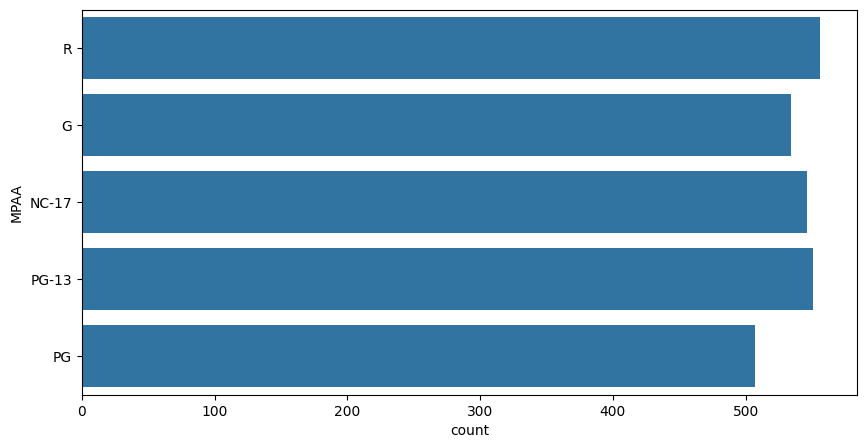

In [16]:
plt.figure(figsize=(10, 5))
sb.countplot(df['MPAA'])
plt.show()


This plot suggests that movies rated PG and R are predominant, which may influence revenue trends, as shown by the higher average revenues for these ratings.

In [17]:
df.groupby('MPAA')['domestic_revenue'].mean()

MPAA
G        3.320203e+06
NC-17    3.095755e+06
PG       3.388151e+06
PG-13    3.070569e+06
R        3.353680e+06
Name: domestic_revenue, dtype: float64

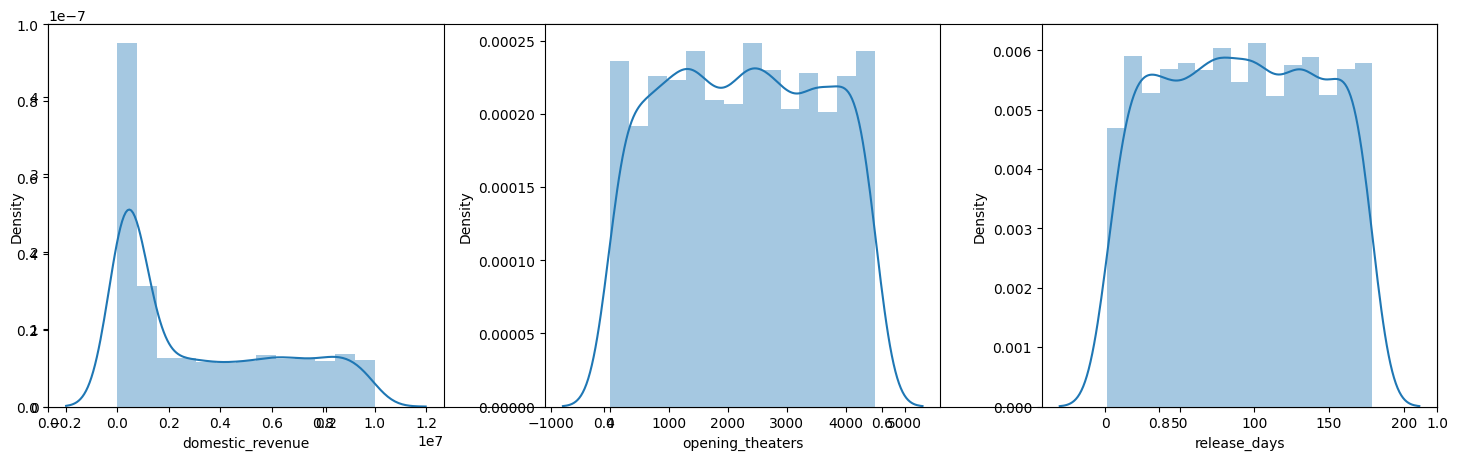

In [18]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

The skewness indicates that most movies earn moderate to low revenue, while a small group achieves significantly higher revenue. This variability may impact model performance, as it creates difficulty in accurately predicting outliers.



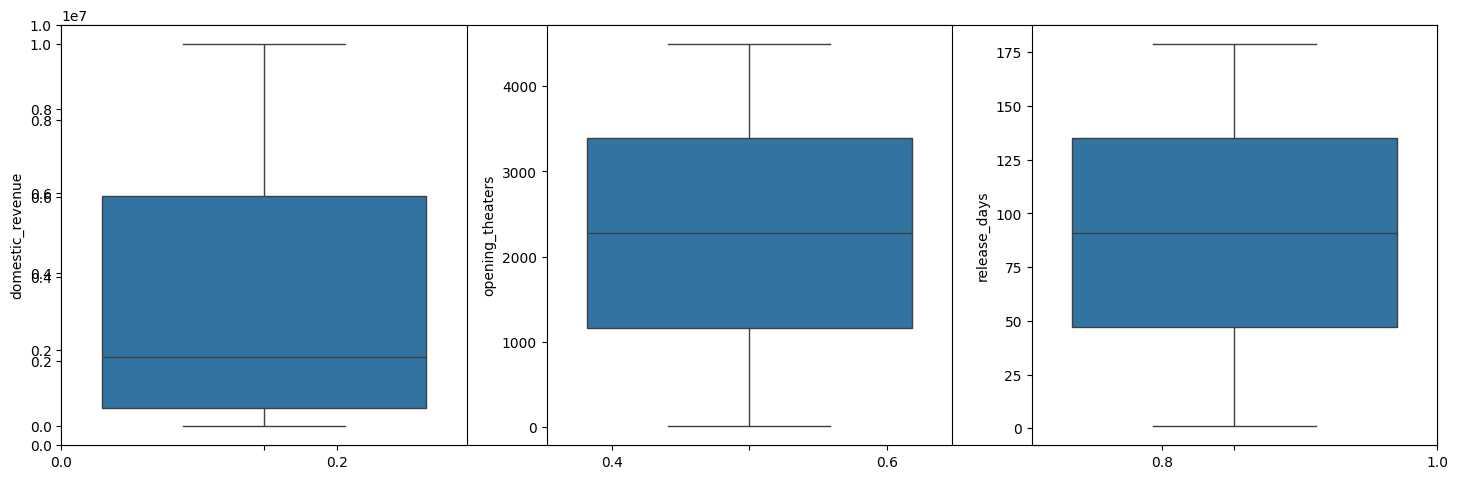

In [19]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()


Outliers in revenue and theater openings reflect blockbuster movies with widespread releases. These outliers could bias model predictions, so normalization or robust models might help handle this skew.

In [20]:
for col in features:
  df[col] = df[col].apply(lambda x: np.log10(x))

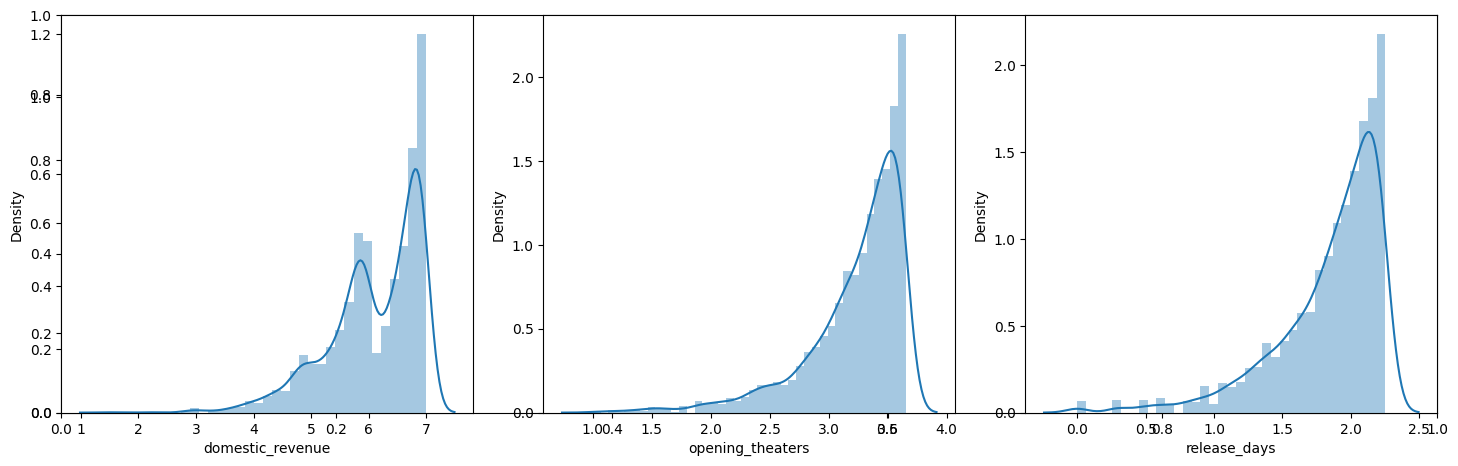

In [21]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

This transformation stabilizes variance and enhances model learning by centering distributions, which may improve predictive performance on revenue data.

In [38]:
# Text Vectorization for 'plot_keywords'
vectorizer = CountVectorizer() 
vectorizer.fit(df['genres']) 
features = vectorizer.transform(df['genres']).toarray() 

genres = vectorizer.get_feature_names_out() 
for i, name in enumerate(genres): 
    df[name] = features[:, i] 

df.drop('genres', axis=1, inplace=True)


In [39]:
removed = 0
# Check if 'action' and 'western' columns exist before slicing
if 'action' in df.columns and 'western' in df.columns:
    for col in df.loc[:, 'action':'western'].columns: 

        # Removing columns having more 
        # than 95% of the values as zero. 
        if (df[col] == 0).mean() > 0.95: 
            removed += 1
            df.drop(col, axis=1, inplace=True) 

print(removed) 
print(df.shape)




0
(2694, 15)


In [24]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


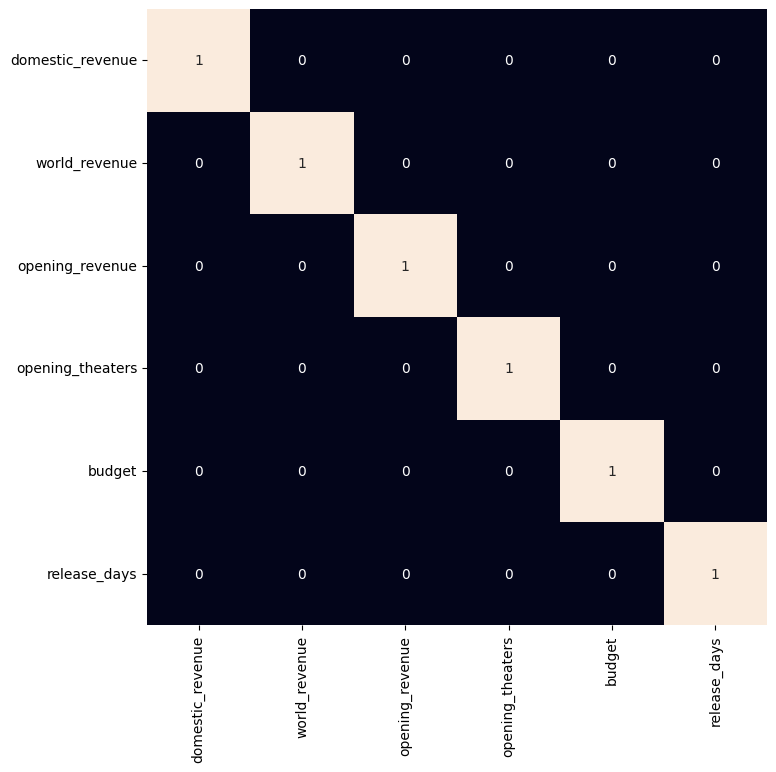

In [37]:
# Visualizing correlation matrix to identify highly correlated features
plt.figure(figsize=(8, 8))
sb.heatmap(df.select_dtypes(include=np.number).corr() > 0.8, 
            annot=True, 
            cbar=False) 
plt.show()




High correlations might suggest multicollinearity, which could impact model performance. Redundant features can be dropped, or regularization methods applied to counteract multicollinearity.

# Model Development

In [36]:
# Splitting the data into features (X) and target (y) and then into training and validation sets
features = df.drop(['title', 'domestic_revenue'], axis=1) 
target = df['domestic_revenue'].values 
# Splitting the data for training and validation
X_train, X_val, Y_train, Y_val = train_test_split(features, target, 
                                    test_size=0.1, 
                                    random_state=22) 
X_train.shape, X_val.shape 




((2424, 8), (270, 8))

In [27]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [35]:
# Initializing and training the XGBRegressor model
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
# Evaluating the model using Mean Absolute Error (MAE) on training and validation data
train_preds = model.predict(X_train) 
print('Training Error : ', mae(Y_train, train_preds)) 

val_preds = model.predict(X_val) 
print('Validation Error : ', mae(Y_val, val_preds)) 
print() 




Training Error :  0.23834028038319702
Validation Error :  0.7129402518337751



The higher validation error suggests slight overfitting, indicating that further tuning or regularization could help enhance generalization. Adjusting hyperparameters, using cross-validation, or reducing feature redundancy could improve model reliability.

#  Hyperparameter Tuning with Randomized Search

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

# Convert categorical columns to numeric with LabelEncoder or One-Hot Encoding
for col in ['distributor', 'MPAA', 'genres']:
    if col in X_train.columns:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))

# Define the parameter distribution for XGBRegressor
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    XGBRegressor(random_state=22),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=22
)

# Fit RandomizedSearchCV
random_search.fit(X_train, Y_train)

# Best parameters and model
best_random_params = random_search.best_params_
best_random_model = random_search.best_estimator_

print("Best Parameters from RandomizedSearchCV:", best_random_params)


Best Parameters from RandomizedSearchCV: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.042222222222222223, 'colsample_bytree': 0.7}


# Using the Tuned Model for Final Evaluation

In [43]:
from sklearn.metrics import mean_absolute_error

# Initialize the model with the best parameters
tuned_model = XGBRegressor(
    subsample=0.8,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.042,
    colsample_bytree=0.7,
    random_state=22
)

# Train the model
tuned_model.fit(X_train, Y_train)

# Predict on training and validation sets
train_preds = tuned_model.predict(X_train)
val_preds = tuned_model.predict(X_val)

# Calculate MAE for training and validation
train_mae = mean_absolute_error(Y_train, train_preds)
val_mae = mean_absolute_error(Y_val, val_preds)

print("Training MAE with Tuned Model:", train_mae)
print("Validation MAE with Tuned Model:", val_mae)


Training MAE with Tuned Model: 64903177.07879538
Validation MAE with Tuned Model: 74850620.72592592
